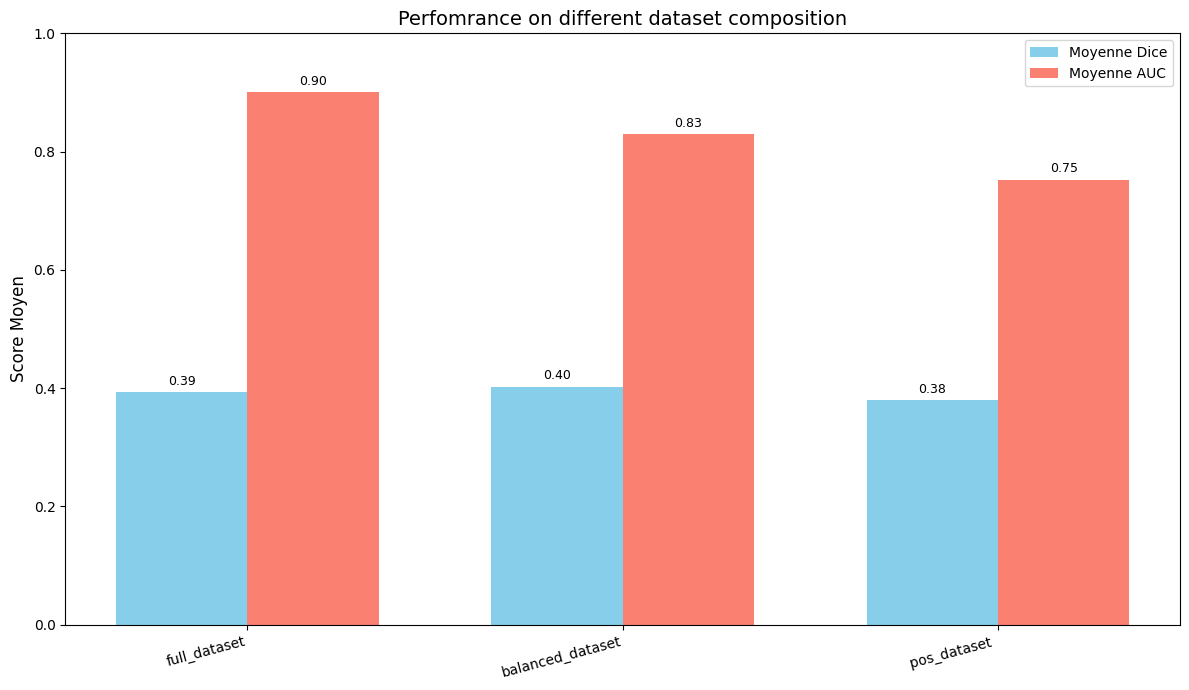

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Données fournies, avec la troisième méthode ajoutée
data = {
    "full_dataset": {
        "dice": [0.2761685848236084, 0.5875270366668701, 0.5139704346656799, 0.2582128942012787, 0.33268705010414124],
        "auc": [0.8946945071220398, 0.9216837286949158, 0.9570945501327516, 0.8653181791305542, 0.8621033430099487]
    },
    "balanced_dataset": {
        "dice": [0.2951441705226898, 0.575005054473877, 0.520770251750946, 0.2732867896556854, 0.3494012951850891],
        "auc": [0.7388888597488403, 0.9023476243019104, 0.9366365075111388, 0.8340278267860413, 0.7395224571228027]
    },
    "pos_dataset ": {
        "dice": [0.26516222953796387, 0.5376638770103455, 0.5078380107879639, 0.30805057287216187, 0.28336724638938904],
        "auc": [0.4943181872367859, 0.7450411319732666, 0.8584409356117249, 0.8340278267860413, 0.8321917653083801]
    }
}

# Calcul des moyennes pour chaque méthode
methods = list(data.keys())
dice_means = []
auc_means = []

for method in methods:
    # Filtre les zéros pour éviter de fausser la moyenne du Dice si certaines classes n'ont pas de score
    dice_values = [d for d in data[method]["dice"] if d > 0]
    auc_values = [a for a in data[method]["auc"] if a > 0]
    
    # Évite une division par zéro si la liste est vide
    dice_mean = np.mean(dice_values) if dice_values else 0
    auc_mean = np.mean(auc_values) if auc_values else 0
    
    dice_means.append(dice_mean)
    auc_means.append(auc_mean)

# Création du graphique
fig, ax = plt.subplots(figsize=(12, 7))
width = 0.35  # Largeur des barres
x = np.arange(len(methods))

# Barres pour le score Dice moyen
rects1 = ax.bar(x - width/2, dice_means, width, label='Moyenne Dice', color='skyblue')

# Barres pour le score AUC moyen
rects2 = ax.bar(x + width/2, auc_means, width, label='Moyenne AUC', color='salmon')

# Étiquettes, titre et légende
ax.set_ylabel('Score Moyen', fontsize=12)
ax.set_title('Perfomrance on different dataset composition', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right', fontsize=10)
ax.legend(fontsize=10)
ax.set_ylim(0, 1)

# Fonction pour afficher les valeurs sur les barres
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

Automatisation avec .csv

In [15]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Config à personnaliser ---
ENTITY = "ad_92_ywlcod-polytechnique-montr-al"
PROJECT = "hemorrhage_multitask_test"
RUNS_TO_COMPARE = ["dfz5c0yp", "z27eq8fo", "hubgefyd", "s3h1nwqn",'t0ors5fa']

# --- Connexion à l'API ---
api = wandb.Api()

data = []

def last_valid(series):
    """Retourne la dernière valeur non NaN d'une série Pandas."""
    valid = series.dropna()
    return valid.iloc[-1] if len(valid) > 0 else np.nan

for run_id in RUNS_TO_COMPARE:
    run = api.run(f"{ENTITY}/{PROJECT}/{run_id}")
    print(f"\n=== Run: {run.name} ({run_id}) ===")
    df = run.history()
    dice_cols = [c for c in df.columns if c.startswith("dice_c")]
    auc_cols = [c for c in df.columns if "val_auc" in c.lower()]
    
    dice_last_values = [last_valid(df[c]) for c in dice_cols]
    auc_last_values = [last_valid(df[c]) for c in auc_cols]

    dice_mean = np.nanmean(dice_last_values)
    auc_mean = np.nanmean(auc_last_values)

    print(f"Run: {run.name}")
    print(f"Dice moyen final : {dice_mean:.4f}")
    print(f"AUC moyen final  : {auc_mean:.4f}")


    data.append({
        "run_name": run.name,
        "dice_mean": dice_mean,
        "auc_mean": auc_mean
    })

df_summary = pd.DataFrame(data)
print(df_summary)



=== Run: sample_slicing_meanagg (dfz5c0yp) ===
Run: sample_slicing_meanagg
Dice moyen final : 0.3778
AUC moyen final  : 0.7389

=== Run: multitask_unet3d_Slicinglimitedsample_slicing_maxagg (z27eq8fo) ===
Run: multitask_unet3d_Slicinglimitedsample_slicing_maxagg
Dice moyen final : 0.3687
AUC moyen final  : 0.7589

=== Run: 25_rd_patchs (hubgefyd) ===
Run: 25_rd_patchs
Dice moyen final : 0.3988
AUC moyen final  : 0.8332

=== Run: unique_patch (s3h1nwqn) ===
Run: unique_patch
Dice moyen final : 0.3697
AUC moyen final  : 0.8636

=== Run: 12_rd_patchs (t0ors5fa) ===
Run: 12_rd_patchs
Dice moyen final : 0.3887
AUC moyen final  : 0.8300
                                            run_name  dice_mean  auc_mean
0                             sample_slicing_meanagg   0.377815  0.738884
1  multitask_unet3d_Slicinglimitedsample_slicing_...   0.368715  0.758870
2                                       25_rd_patchs   0.398810  0.833247
3                                       unique_patch   0.369731 

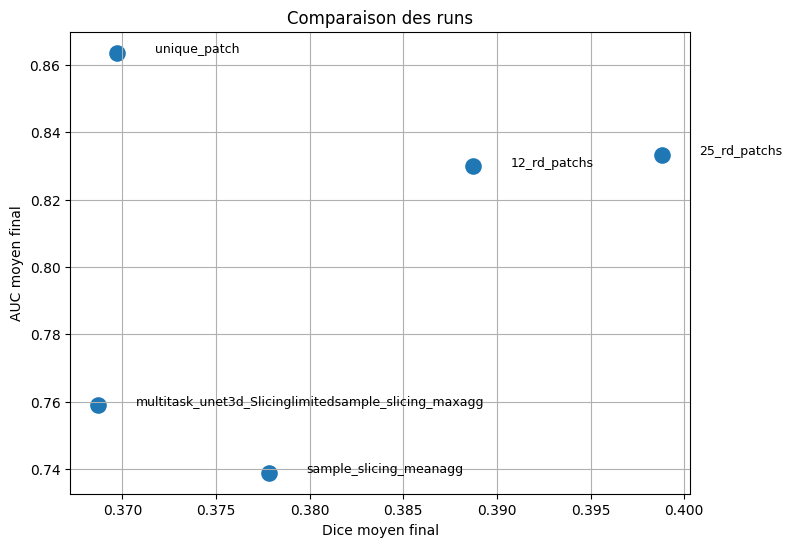

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_summary["dice_mean"], df_summary["auc_mean"], s=120)

for _, row in df_summary.iterrows():
    plt.text(row["dice_mean"]+0.002, row["auc_mean"], row["run_name"], fontsize=9)

plt.xlabel("Dice moyen final")
plt.ylabel("AUC moyen final")
plt.title("Comparaison des runs")
plt.grid(True)
plt.show()